In [1]:
# !pip install shap

In [2]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [3]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [4]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [5]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [6]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [7]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [9]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [10]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [11]:
class Embedding(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.position_embeddings = nn.Embedding(config.sequence_length, config.input_feature)
    self.norm_layer = nn.LayerNorm(config.input_feature , eps=1e-12)
    self.dropout = nn.Dropout()

  def forward(self, input_tensor):
      device = input_tensor.device  # input_tensor의 디바이스를 가져옵니다.
      input_pos = torch.arange(input_tensor.size(1), dtype=torch.long, device=device)  # 디바이스를 지정하여 input_pos를 생성합니다.
      pos_emb = self.position_embeddings(input_pos).unsqueeze(0)
      final_emb = input_tensor + pos_emb
      final_emb = self.norm_layer(final_emb)
      final_emb = self.dropout(final_emb)
      return final_emb

In [12]:
from math import sqrt
def scaled_dot_product(query,key,value):
  dim_k = query.size(-1)
  similiarity = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
  similiarity = F.softmax(similiarity, dim = -1) #여기 조심하자
  return torch.bmm(similiarity,value)

In [13]:
class Attention_head(nn.Module):
  def __init__(self, emb_dim, head_dim):
    super().__init__()
    self.query = nn.Linear(emb_dim, head_dim)
    self.key = nn.Linear(emb_dim, head_dim)
    self.value = nn.Linear(emb_dim, head_dim)

  def forward(self, final_emb):
    q = self.query(final_emb)
    k = self.key(final_emb)
    v = self.value(final_emb)
    return scaled_dot_product(q, k, v)

In [14]:
class Multihead_attention(nn.Module):
  def __init__(self,config):
    super().__init__()
    input_feature = config.input_feature
    self.attention_heads = nn.ModuleList([Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,3)])
    self.dense_layer = nn.Linear(input_feature, input_feature)

  def forward(self, final_emb):
    x = torch.cat([h(final_emb) for h in self.attention_heads],dim = -1)
    x = self.dense_layer(x)
    return x

In [15]:
class Feedforward(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.layer1 = nn.Linear(config.input_feature, config.feed_foward_dim)
    self.layer2 = nn.Linear(config.feed_foward_dim, config.input_feature)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout()

  def forward(self, x):
    x = self.layer1(x)
    x = self.gelu(x)
    x = self.layer2(x)
    x = self.dropout(x)
    return x

In [16]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.Norm1 = nn.LayerNorm(config.input_feature)
    self.Norm2 = nn.LayerNorm(config.input_feature)
    self.attention = Multihead_attention(config)
    self.feedforward = Feedforward(config)

  def forward(self,x):
    norm = self.Norm1(x)
    x = x + self.attention(norm)
    x = x + self.feedforward(self.Norm2(x))
    return x

In [17]:
class AttentionMechanism(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        dim_k = q.size(-1)

        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / (dim_k ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        weighted_average = torch.matmul(attention_weights, x)

        return weighted_average.mean(dim=1)

In [18]:
class TransformerEncoder(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.embedding = Embedding(config)
    self.layers = nn.ModuleList([TransformerEncoderLayer(config) for i in range(config.num_layers)])
    self.attention = AttentionMechanism(config.input_feature)
    self.classifier = nn.Linear(config.input_feature, 2)

  def forward(self,x):
    x = self.embedding(x)
    for layer in self.layers:
      x = layer(x)
    x = self.attention(x)
    x = self.classifier(x)
    return x

# trainer 구현

In [19]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [20]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 3000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_feature = 19     # input feature 이거 바꾸면 모델 안 돌아감
  feed_foward_dim = 100  # feed forward dimension
  num_layers = 12        # encoder block 개수

config = Config()

In [21]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [22]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [23]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


In [24]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 3000
failure(1)의 개수 : 1569


In [25]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [26]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [27]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [28]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 2741
Total number of data samples in valid_loader: 913
Total number of data samples in test_loader: 914


In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [30]:
# model, optimizer, loss_function 구현하고 결합시키기
model = TransformerEncoder(config)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [30]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/3000_Transformer') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 4/4 [00:00<00:00, 102.63it/s]


Model saved
TRAIN LOSS = 0.002816801934901575, TRAIN ACC = 0.6213060926669098, 
VALID LOSS = 0.002628008872760217, VALID ACC = 0.6659364731653888, 
epoch 2


100%|██████████| 4/4 [00:00<00:00, 96.40it/s]


Model saved
TRAIN LOSS = 0.002325025952153726, TRAIN ACC = 0.7150674936154688, 
VALID LOSS = 0.00265249358602317, VALID ACC = 0.6670317634173056, 
epoch 3


100%|██████████| 4/4 [00:00<00:00, 101.85it/s]


TRAIN LOSS = 0.002230400349353622, TRAIN ACC = 0.7212696096315213, 
VALID LOSS = 0.002652417921419342, VALID ACC = 0.6637458926615553, 
epoch 4


100%|██████████| 4/4 [00:00<00:00, 101.42it/s]


TRAIN LOSS = 0.0021751626309405624, TRAIN ACC = 0.7285662167092302, 
VALID LOSS = 0.002649700197698253, VALID ACC = 0.6659364731653888, 
epoch 5


100%|██████████| 4/4 [00:00<00:00, 101.78it/s]


Model saved
TRAIN LOSS = 0.002125612502548652, TRAIN ACC = 0.7373221452024808, 
VALID LOSS = 0.0026370789631303534, VALID ACC = 0.6812705366922235, 
epoch 6


100%|██████████| 4/4 [00:00<00:00, 99.94it/s]


Model saved
TRAIN LOSS = 0.0021149877517252064, TRAIN ACC = 0.7402407880335644, 
VALID LOSS = 0.002690327650615446, VALID ACC = 0.6889375684556407, 
epoch 7


100%|██████████| 4/4 [00:00<00:00, 101.82it/s]


Model saved
TRAIN LOSS = 0.0020961241755160223, TRAIN ACC = 0.7314848595403137, 
VALID LOSS = 0.002562725073928248, VALID ACC = 0.7009857612267251, 
epoch 8


100%|██████████| 4/4 [00:00<00:00, 102.44it/s]


TRAIN LOSS = 0.0020398967177360783, TRAIN ACC = 0.7471725647573878, 
VALID LOSS = 0.002430165976057439, VALID ACC = 0.7009857612267251, 
epoch 9


100%|██████████| 4/4 [00:00<00:00, 102.29it/s]


Model saved
TRAIN LOSS = 0.0020284469394690795, TRAIN ACC = 0.7384166362641372, 
VALID LOSS = 0.0023359677224926985, VALID ACC = 0.7207009857612268, 
epoch 10


100%|██████████| 4/4 [00:00<00:00, 99.76it/s]


Model saved
TRAIN LOSS = 0.002005833359105619, TRAIN ACC = 0.7457132433418461, 
VALID LOSS = 0.002407328942780427, VALID ACC = 0.7360350492880613, 
epoch 11


100%|██████████| 4/4 [00:00<00:00, 99.47it/s]


TRAIN LOSS = 0.0019969203227717092, TRAIN ACC = 0.748996716526815, 
VALID LOSS = 0.002526681825339076, VALID ACC = 0.7152245345016429, 
epoch 12


100%|██████████| 4/4 [00:00<00:00, 102.42it/s]


Model saved
TRAIN LOSS = 0.0019831028092477236, TRAIN ACC = 0.7442539219263042, 
VALID LOSS = 0.00222916449017227, VALID ACC = 0.7437020810514786, 
epoch 13


100%|██████████| 4/4 [00:00<00:00, 101.15it/s]


TRAIN LOSS = 0.0019248017252296134, TRAIN ACC = 0.7413352790952207, 
VALID LOSS = 0.002268783070824363, VALID ACC = 0.7426067907995619, 
epoch 14


100%|██████████| 4/4 [00:00<00:00, 102.02it/s]


Model saved
TRAIN LOSS = 0.0019103404337017695, TRAIN ACC = 0.752280189711784, 
VALID LOSS = 0.00223507899444179, VALID ACC = 0.7502738225629791, 
epoch 15


100%|██████████| 4/4 [00:00<00:00, 101.75it/s]


Model saved
TRAIN LOSS = 0.001913528858158372, TRAIN ACC = 0.7453484129879606, 
VALID LOSS = 0.0022378654626217494, VALID ACC = 0.7590361445783133, 
epoch 16


100%|██████████| 4/4 [00:00<00:00, 91.91it/s]


Model saved
TRAIN LOSS = 0.0019047049569718292, TRAIN ACC = 0.7530098504195549, 
VALID LOSS = 0.0024743787169064775, VALID ACC = 0.76013143483023, 
epoch 17


100%|██████████| 4/4 [00:00<00:00, 102.30it/s]


Model saved
TRAIN LOSS = 0.0019212009066519446, TRAIN ACC = 0.7460780736957315, 
VALID LOSS = 0.0023921443494230605, VALID ACC = 0.7612267250821467, 
epoch 18


100%|██████████| 4/4 [00:00<00:00, 100.67it/s]


TRAIN LOSS = 0.0018721257126796684, TRAIN ACC = 0.7635899306822328, 
VALID LOSS = 0.0022216524443255587, VALID ACC = 0.7513691128148959, 
epoch 19


100%|██████████| 4/4 [00:00<00:00, 103.12it/s]


Model saved
TRAIN LOSS = 0.0018400714502679045, TRAIN ACC = 0.7719810288215979, 
VALID LOSS = 0.0022394532115409824, VALID ACC = 0.7754654983570646, 
epoch 20


100%|██████████| 4/4 [00:00<00:00, 101.98it/s]


TRAIN LOSS = 0.001847461132357826, TRAIN ACC = 0.7683327252827435, 
VALID LOSS = 0.002294631411708067, VALID ACC = 0.764512595837897, 
epoch 21


100%|██████████| 4/4 [00:00<00:00, 87.95it/s]


TRAIN LOSS = 0.0018518925126300855, TRAIN ACC = 0.7603064574972638, 
VALID LOSS = 0.0022031264328617123, VALID ACC = 0.7743702081051479, 
epoch 22


100%|██████████| 4/4 [00:00<00:00, 99.48it/s]


TRAIN LOSS = 0.0018473006064593466, TRAIN ACC = 0.762130609266691, 
VALID LOSS = 0.002189032513105595, VALID ACC = 0.7699890470974808, 
epoch 23


100%|██████████| 4/4 [00:00<00:00, 101.89it/s]


TRAIN LOSS = 0.0017964920611418063, TRAIN ACC = 0.7676030645749726, 
VALID LOSS = 0.0022742774374252604, VALID ACC = 0.7699890470974808, 
epoch 24


100%|██████████| 4/4 [00:00<00:00, 100.07it/s]


TRAIN LOSS = 0.0018196187720425762, TRAIN ACC = 0.7701568770521707, 
VALID LOSS = 0.0021904736006508, VALID ACC = 0.764512595837897, 
epoch 25


100%|██████████| 4/4 [00:00<00:00, 102.18it/s]


Model saved
TRAIN LOSS = 0.0018172486338985962, TRAIN ACC = 0.76541408245166, 
VALID LOSS = 0.0021814697739328506, VALID ACC = 0.7765607886089814, 
epoch 26


100%|██████████| 4/4 [00:00<00:00, 101.21it/s]


Model saved
TRAIN LOSS = 0.0017639834682509135, TRAIN ACC = 0.7730755198832543, 
VALID LOSS = 0.0022055216190718352, VALID ACC = 0.7831325301204819, 
epoch 27


100%|██████████| 4/4 [00:00<00:00, 101.82it/s]


TRAIN LOSS = 0.0017941467129631837, TRAIN ACC = 0.7734403502371398, 
VALID LOSS = 0.002227988391951428, VALID ACC = 0.7447973713033954, 
epoch 28


100%|██████████| 4/4 [00:00<00:00, 102.16it/s]


Model saved
TRAIN LOSS = 0.001779826876456961, TRAIN ACC = 0.7770886537759941, 
VALID LOSS = 0.0021838191305037264, VALID ACC = 0.7842278203723987, 
epoch 29


100%|██████████| 4/4 [00:00<00:00, 102.38it/s]


Model saved
TRAIN LOSS = 0.0017632825645988155, TRAIN ACC = 0.7803721269609631, 
VALID LOSS = 0.0022193497008065667, VALID ACC = 0.7853231106243155, 
epoch 30


100%|██████████| 4/4 [00:00<00:00, 95.04it/s]


TRAIN LOSS = 0.0017929104439144976, TRAIN ACC = 0.7705217074060562, 
VALID LOSS = 0.0021566367031841133, VALID ACC = 0.7656078860898138, 
epoch 31


100%|██████████| 4/4 [00:00<00:00, 100.82it/s]


TRAIN LOSS = 0.001762578072925416, TRAIN ACC = 0.7847500912075884, 
VALID LOSS = 0.0022325824542217946, VALID ACC = 0.7579408543263965, 
epoch 32


100%|██████████| 4/4 [00:00<00:00, 100.93it/s]


TRAIN LOSS = 0.0017717570468745324, TRAIN ACC = 0.7825611090842758, 
VALID LOSS = 0.0021752681815741747, VALID ACC = 0.7710843373493976, 
epoch 33


100%|██████████| 4/4 [00:00<00:00, 97.11it/s]


TRAIN LOSS = 0.0017484388987281296, TRAIN ACC = 0.7858445822692448, 
VALID LOSS = 0.0020706772086132004, VALID ACC = 0.768893756845564, 
epoch 34


100%|██████████| 4/4 [00:00<00:00, 102.45it/s]


TRAIN LOSS = 0.0017113491854759864, TRAIN ACC = 0.7898577161619846, 
VALID LOSS = 0.0020539431556292195, VALID ACC = 0.7612267250821467, 
epoch 35


100%|██████████| 4/4 [00:00<00:00, 101.49it/s]


TRAIN LOSS = 0.001707066718960539, TRAIN ACC = 0.7869390733309012, 
VALID LOSS = 0.0021591564193612777, VALID ACC = 0.7480832420591457, 
epoch 36


100%|██████████| 4/4 [00:00<00:00, 101.89it/s]


TRAIN LOSS = 0.001667707734454161, TRAIN ACC = 0.7883983947464429, 
VALID LOSS = 0.002187086875180164, VALID ACC = 0.7634173055859803, 
epoch 37


100%|██████████| 4/4 [00:00<00:00, 101.21it/s]


TRAIN LOSS = 0.0017182461126404756, TRAIN ACC = 0.7894928858080993, 
VALID LOSS = 0.002350422240557049, VALID ACC = 0.7612267250821467, 
epoch 38


100%|██████████| 4/4 [00:00<00:00, 101.54it/s]


TRAIN LOSS = 0.0017111633259725588, TRAIN ACC = 0.7924115286391827, 
VALID LOSS = 0.002218915167930745, VALID ACC = 0.7656078860898138, 
epoch 39


100%|██████████| 4/4 [00:00<00:00, 101.57it/s]


TRAIN LOSS = 0.0017045409368016083, TRAIN ACC = 0.7847500912075884, 
VALID LOSS = 0.001998035728866143, VALID ACC = 0.7743702081051479, 
epoch 40


100%|██████████| 4/4 [00:00<00:00, 101.26it/s]


TRAIN LOSS = 0.0016392516920228197, TRAIN ACC = 0.790952207223641, 
VALID LOSS = 0.0021380634911089057, VALID ACC = 0.755750273822563, 
epoch 41


100%|██████████| 4/4 [00:00<00:00, 101.64it/s]


TRAIN LOSS = 0.001652045260376845, TRAIN ACC = 0.8018971178402043, 
VALID LOSS = 0.0019292397932572799, VALID ACC = 0.7820372398685652, 
epoch 42


100%|██████████| 4/4 [00:00<00:00, 101.65it/s]


TRAIN LOSS = 0.0016167538307827348, TRAIN ACC = 0.7978839839474644, 
VALID LOSS = 0.0019264937361124965, VALID ACC = 0.7765607886089814, 
epoch 43


100%|██████████| 4/4 [00:00<00:00, 100.44it/s]


TRAIN LOSS = 0.0015723534697644338, TRAIN ACC = 0.8102882159795695, 
VALID LOSS = 0.0021498020481305995, VALID ACC = 0.7524644030668127, 
epoch 44


100%|██████████| 4/4 [00:00<00:00, 101.37it/s]


TRAIN LOSS = 0.0015368311890543312, TRAIN ACC = 0.8201386355344765, 
VALID LOSS = 0.00203807937615803, VALID ACC = 0.7634173055859803, 
epoch 45


100%|██████████| 4/4 [00:00<00:00, 85.97it/s]


TRAIN LOSS = 0.0015777015024969413, TRAIN ACC = 0.8015322874863189, 
VALID LOSS = 0.002063131312812145, VALID ACC = 0.7656078860898138, 
epoch 46


100%|██████████| 4/4 [00:00<00:00, 101.12it/s]


Model saved
TRAIN LOSS = 0.0015543202269212124, TRAIN ACC = 0.8139365195184239, 
VALID LOSS = 0.0019233508151828393, VALID ACC = 0.7940854326396495, 
epoch 47


100%|██████████| 4/4 [00:00<00:00, 101.47it/s]


TRAIN LOSS = 0.0015213311544868555, TRAIN ACC = 0.8106530463334549, 
VALID LOSS = 0.0019033597568039826, VALID ACC = 0.7940854326396495, 
epoch 48


100%|██████████| 4/4 [00:00<00:00, 101.48it/s]


TRAIN LOSS = 0.0015600684001384013, TRAIN ACC = 0.816490331995622, 
VALID LOSS = 0.0020377309207456657, VALID ACC = 0.7842278203723987, 
epoch 49


100%|██████████| 4/4 [00:00<00:00, 101.72it/s]


Model saved
TRAIN LOSS = 0.0015327940670863767, TRAIN ACC = 0.8102882159795695, 
VALID LOSS = 0.0017670605490790008, VALID ACC = 0.8061336254107339, 
epoch 50


100%|██████████| 4/4 [00:00<00:00, 101.28it/s]


TRAIN LOSS = 0.0015156482071478146, TRAIN ACC = 0.8143013498723094, 
VALID LOSS = 0.0019100176870235346, VALID ACC = 0.7940854326396495, 
epoch 51


100%|██████████| 4/4 [00:00<00:00, 101.58it/s]


TRAIN LOSS = 0.0014933537975883274, TRAIN ACC = 0.8146661802261949, 
VALID LOSS = 0.001959692086995888, VALID ACC = 0.791894852135816, 
epoch 52


100%|██████████| 4/4 [00:00<00:00, 98.61it/s]


TRAIN LOSS = 0.0014379296869050408, TRAIN ACC = 0.8245165997811018, 
VALID LOSS = 0.0018226403787911657, VALID ACC = 0.7853231106243155, 
epoch 53


100%|██████████| 4/4 [00:00<00:00, 101.99it/s]


TRAIN LOSS = 0.001508728305774203, TRAIN ACC = 0.8135716891645385, 
VALID LOSS = 0.0017660955152793624, VALID ACC = 0.80065717415115, 
epoch 54


100%|██████████| 4/4 [00:00<00:00, 101.98it/s]


TRAIN LOSS = 0.0014483887037627238, TRAIN ACC = 0.82305727836556, 
VALID LOSS = 0.0017679727678100486, VALID ACC = 0.791894852135816, 
epoch 55


100%|██████████| 4/4 [00:00<00:00, 101.30it/s]


TRAIN LOSS = 0.001440142778443925, TRAIN ACC = 0.8259759211966435, 
VALID LOSS = 0.0017126093558387716, VALID ACC = 0.8050383351588171, 
epoch 56


100%|██████████| 4/4 [00:00<00:00, 100.18it/s]


Model saved
TRAIN LOSS = 0.001420502721806679, TRAIN ACC = 0.8256110908427581, 
VALID LOSS = 0.0016008049804566331, VALID ACC = 0.8170865279299014, 
epoch 57


100%|██████████| 4/4 [00:00<00:00, 100.50it/s]


TRAIN LOSS = 0.0013785196759760793, TRAIN ACC = 0.8347318496898942, 
VALID LOSS = 0.0019223182773276722, VALID ACC = 0.7886089813800657, 
epoch 58


100%|██████████| 4/4 [00:00<00:00, 98.73it/s]


TRAIN LOSS = 0.0014017930390929619, TRAIN ACC = 0.8307187157971543, 
VALID LOSS = 0.0017934333847229738, VALID ACC = 0.7776560788608982, 
epoch 59


100%|██████████| 4/4 [00:00<00:00, 101.06it/s]


TRAIN LOSS = 0.0014136753152731083, TRAIN ACC = 0.8248814301349873, 
VALID LOSS = 0.0017672457282410002, VALID ACC = 0.7984665936473165, 
epoch 60


100%|██████████| 4/4 [00:00<00:00, 102.00it/s]


TRAIN LOSS = 0.0014610520486890812, TRAIN ACC = 0.8336373586282378, 
VALID LOSS = 0.0017939415910288381, VALID ACC = 0.7940854326396495, 
epoch 61


100%|██████████| 4/4 [00:00<00:00, 101.19it/s]


TRAIN LOSS = 0.001351775956910616, TRAIN ACC = 0.8350966800437797, 
VALID LOSS = 0.001589718745023763, VALID ACC = 0.8116100766703176, 
epoch 62


100%|██████████| 4/4 [00:00<00:00, 101.70it/s]


TRAIN LOSS = 0.001359083940842777, TRAIN ACC = 0.8438526085370303, 
VALID LOSS = 0.0019593052117221326, VALID ACC = 0.7699890470974808, 
epoch 63


100%|██████████| 4/4 [00:00<00:00, 101.93it/s]


TRAIN LOSS = 0.0014124267382240783, TRAIN ACC = 0.8321780372126961, 
VALID LOSS = 0.002124848592973356, VALID ACC = 0.7710843373493976, 
epoch 64


100%|██████████| 4/4 [00:00<00:00, 101.69it/s]


TRAIN LOSS = 0.001345474032405866, TRAIN ACC = 0.8380153228748631, 
VALID LOSS = 0.0019732072280244524, VALID ACC = 0.7940854326396495, 
epoch 65


100%|██████████| 4/4 [00:00<00:00, 102.25it/s]


TRAIN LOSS = 0.0013388440105350555, TRAIN ACC = 0.8438526085370303, 
VALID LOSS = 0.0017339467414759857, VALID ACC = 0.8039430449069004, 
epoch 66


100%|██████████| 4/4 [00:00<00:00, 99.64it/s]


TRAIN LOSS = 0.001310362449661305, TRAIN ACC = 0.8475009120758847, 
VALID LOSS = 0.0017662358767101042, VALID ACC = 0.7962760131434831, 
epoch 67


100%|██████████| 4/4 [00:00<00:00, 101.90it/s]


TRAIN LOSS = 0.00131448729331369, TRAIN ACC = 0.8496898941991974, 
VALID LOSS = 0.0018625693214161633, VALID ACC = 0.8094194961664841, 
epoch 68


100%|██████████| 4/4 [00:00<00:00, 100.49it/s]


TRAIN LOSS = 0.00131422503070212, TRAIN ACC = 0.8478657424297702, 
VALID LOSS = 0.0020162355795355774, VALID ACC = 0.80065717415115, 
epoch 69


100%|██████████| 4/4 [00:00<00:00, 102.17it/s]


Model saved
TRAIN LOSS = 0.0013807750518023641, TRAIN ACC = 0.8383801532287486, 
VALID LOSS = 0.0017622030969517385, VALID ACC = 0.8357064622124863, 
epoch 70


100%|██████████| 4/4 [00:00<00:00, 102.48it/s]


TRAIN LOSS = 0.0012628413690610855, TRAIN ACC = 0.8438526085370303, 
VALID LOSS = 0.0018333321333192656, VALID ACC = 0.8159912376779846, 
epoch 71


100%|██████████| 4/4 [00:00<00:00, 102.06it/s]


TRAIN LOSS = 0.001245101169703086, TRAIN ACC = 0.8562568405691353, 
VALID LOSS = 0.0018666435241176944, VALID ACC = 0.7929901423877328, 
epoch 72


100%|██████████| 4/4 [00:00<00:00, 102.07it/s]


TRAIN LOSS = 0.001277971761324944, TRAIN ACC = 0.8547975191535936, 
VALID LOSS = 0.0020347030309048305, VALID ACC = 0.80065717415115, 
epoch 73


100%|██████████| 4/4 [00:00<00:00, 100.39it/s]


TRAIN LOSS = 0.0012459707103563635, TRAIN ACC = 0.8635534476468442, 
VALID LOSS = 0.0023973556102823714, VALID ACC = 0.7677984665936474, 
epoch 74


100%|██████████| 4/4 [00:00<00:00, 100.43it/s]


TRAIN LOSS = 0.0012469509142848186, TRAIN ACC = 0.8544326887997081, 
VALID LOSS = 0.0018044402996263786, VALID ACC = 0.8192771084337349, 
epoch 75


100%|██████████| 4/4 [00:00<00:00, 101.11it/s]


TRAIN LOSS = 0.0012814077918697387, TRAIN ACC = 0.8511492156147391, 
VALID LOSS = 0.0017079872539244503, VALID ACC = 0.8083242059145673, 
epoch 76


100%|██████████| 4/4 [00:00<00:00, 102.07it/s]


TRAIN LOSS = 0.0012277245238852823, TRAIN ACC = 0.8591754834002189, 
VALID LOSS = 0.0019113118846993586, VALID ACC = 0.7842278203723987, 
epoch 77


100%|██████████| 4/4 [00:00<00:00, 101.17it/s]


TRAIN LOSS = 0.0012045448244335617, TRAIN ACC = 0.8628237869390734, 
VALID LOSS = 0.002107234767598364, VALID ACC = 0.8028477546549836, 
epoch 78


100%|██████████| 4/4 [00:00<00:00, 101.74it/s]


TRAIN LOSS = 0.0012373632103454802, TRAIN ACC = 0.8628237869390734, 
VALID LOSS = 0.001762866647455021, VALID ACC = 0.8072289156626506, 
epoch 79


100%|██████████| 4/4 [00:00<00:00, 101.09it/s]


TRAIN LOSS = 0.0011947007454994254, TRAIN ACC = 0.8661072601240423, 
VALID LOSS = 0.0022530258681139575, VALID ACC = 0.7820372398685652, 
epoch 80


100%|██████████| 4/4 [00:00<00:00, 90.14it/s]


TRAIN LOSS = 0.0012066038104575378, TRAIN ACC = 0.8661072601240423, 
VALID LOSS = 0.0017432799279232798, VALID ACC = 0.8346111719605696, 
epoch 81


100%|██████████| 4/4 [00:00<00:00, 97.91it/s]


TRAIN LOSS = 0.0011707501922894115, TRAIN ACC = 0.8686610726012404, 
VALID LOSS = 0.002049368352252839, VALID ACC = 0.7897042716319824, 
epoch 82


100%|██████████| 4/4 [00:00<00:00, 101.29it/s]


TRAIN LOSS = 0.0011537281843225088, TRAIN ACC = 0.8752280189711784, 
VALID LOSS = 0.0017277940797649103, VALID ACC = 0.8181818181818182, 
epoch 83


100%|██████████| 4/4 [00:00<00:00, 86.95it/s]


TRAIN LOSS = 0.0012070295237485878, TRAIN ACC = 0.8602699744618753, 
VALID LOSS = 0.0020262956423409534, VALID ACC = 0.8138006571741512, 
epoch 84


100%|██████████| 4/4 [00:00<00:00, 102.58it/s]


TRAIN LOSS = 0.0011545141458250406, TRAIN ACC = 0.8668369208318132, 
VALID LOSS = 0.0020156353875292873, VALID ACC = 0.8094194961664841, 
epoch 85


100%|██████████| 4/4 [00:00<00:00, 102.47it/s]


TRAIN LOSS = 0.0011648753075563139, TRAIN ACC = 0.8708500547245531, 
VALID LOSS = 0.002364468045720396, VALID ACC = 0.7754654983570646, 
epoch 86


100%|██████████| 4/4 [00:00<00:00, 101.11it/s]


TRAIN LOSS = 0.0011479953254326031, TRAIN ACC = 0.8679314118934696, 
VALID LOSS = 0.0022357126773382982, VALID ACC = 0.7886089813800657, 
epoch 87


100%|██████████| 4/4 [00:00<00:00, 86.78it/s]


TRAIN LOSS = 0.001116514771317792, TRAIN ACC = 0.8752280189711784, 
VALID LOSS = 0.001677233476889486, VALID ACC = 0.8247535596933188, 
epoch 88


100%|██████████| 4/4 [00:00<00:00, 101.82it/s]


TRAIN LOSS = 0.0011488252510688723, TRAIN ACC = 0.868296242247355, 
VALID LOSS = 0.0020467213315222116, VALID ACC = 0.791894852135816, 
epoch 89


100%|██████████| 4/4 [00:00<00:00, 101.84it/s]


TRAIN LOSS = 0.0011621416484905132, TRAIN ACC = 0.8675665815395841, 
VALID LOSS = 0.0022137415108779957, VALID ACC = 0.7721796276013143, 
epoch 90


100%|██████████| 4/4 [00:00<00:00, 101.63it/s]


TRAIN LOSS = 0.0011849685856479225, TRAIN ACC = 0.8569865012769062, 
VALID LOSS = 0.002263665362490751, VALID ACC = 0.7929901423877328, 
epoch 91


100%|██████████| 4/4 [00:00<00:00, 101.66it/s]


TRAIN LOSS = 0.0011440934501221389, TRAIN ACC = 0.8693907333090113, 
VALID LOSS = 0.0022147070995949185, VALID ACC = 0.8039430449069004, 
epoch 92


100%|██████████| 4/4 [00:00<00:00, 101.13it/s]


TRAIN LOSS = 0.0010536379054792168, TRAIN ACC = 0.8865377599416271, 
VALID LOSS = 0.0017921091235872167, VALID ACC = 0.8258488499452354, 
epoch 93


100%|██████████| 4/4 [00:00<00:00, 101.09it/s]


TRAIN LOSS = 0.00112439437053448, TRAIN ACC = 0.8701203940167822, 
VALID LOSS = 0.0021414456793146875, VALID ACC = 0.8039430449069004, 
epoch 94


100%|██████████| 4/4 [00:00<00:00, 101.54it/s]


TRAIN LOSS = 0.0011375176236821717, TRAIN ACC = 0.8737686975556366, 
VALID LOSS = 0.002022391342255006, VALID ACC = 0.7951807228915663, 
epoch 95


100%|██████████| 4/4 [00:00<00:00, 101.33it/s]


TRAIN LOSS = 0.001110127609561543, TRAIN ACC = 0.8726742064939803, 
VALID LOSS = 0.0017535676700261963, VALID ACC = 0.8258488499452354, 
epoch 96


100%|██████████| 4/4 [00:00<00:00, 101.69it/s]


TRAIN LOSS = 0.001068026131846008, TRAIN ACC = 0.8828894564027727, 
VALID LOSS = 0.0017623743705394365, VALID ACC = 0.8203723986856517, 
epoch 97


100%|██████████| 4/4 [00:00<00:00, 101.51it/s]


TRAIN LOSS = 0.0011055746551675112, TRAIN ACC = 0.8817949653411163, 
VALID LOSS = 0.0021188020183901665, VALID ACC = 0.7973713033953997, 
epoch 98


100%|██████████| 4/4 [00:00<00:00, 101.47it/s]


TRAIN LOSS = 0.0011110554011970139, TRAIN ACC = 0.8737686975556366, 
VALID LOSS = 0.0018797657184245684, VALID ACC = 0.8094194961664841, 
epoch 99


100%|██████████| 4/4 [00:00<00:00, 92.30it/s]


TRAIN LOSS = 0.0010906272791720184, TRAIN ACC = 0.8774170010944911, 
VALID LOSS = 0.0026019762014115365, VALID ACC = 0.7469879518072289, 
epoch 100


100%|██████████| 4/4 [00:00<00:00, 101.43it/s]


Model saved
TRAIN LOSS = 0.001073145580439618, TRAIN ACC = 0.8774170010944911, 
VALID LOSS = 0.0015927736952427575, VALID ACC = 0.8411829134720701, 
epoch 101


100%|██████████| 4/4 [00:00<00:00, 101.91it/s]


TRAIN LOSS = 0.0010799079676780854, TRAIN ACC = 0.8828894564027727, 
VALID LOSS = 0.002383891945992477, VALID ACC = 0.7995618838992333, 
epoch 102


100%|██████████| 4/4 [00:00<00:00, 101.76it/s]


TRAIN LOSS = 0.0010731658310143889, TRAIN ACC = 0.8774170010944911, 
VALID LOSS = 0.0021113188608844337, VALID ACC = 0.8094194961664841, 
epoch 103


100%|██████████| 4/4 [00:00<00:00, 101.66it/s]


TRAIN LOSS = 0.001053437280724493, TRAIN ACC = 0.8854432688799708, 
VALID LOSS = 0.0023648256735890483, VALID ACC = 0.7820372398685652, 
epoch 104


100%|██████████| 4/4 [00:00<00:00, 101.76it/s]


TRAIN LOSS = 0.0010943201522416591, TRAIN ACC = 0.8774170010944911, 
VALID LOSS = 0.0019220557688099922, VALID ACC = 0.8094194961664841, 
epoch 105


100%|██████████| 4/4 [00:00<00:00, 100.90it/s]


TRAIN LOSS = 0.0010585865479496785, TRAIN ACC = 0.8817949653411163, 
VALID LOSS = 0.002208953358126888, VALID ACC = 0.7853231106243155, 
epoch 106


100%|██████████| 4/4 [00:00<00:00, 102.09it/s]


TRAIN LOSS = 0.001021185921778952, TRAIN ACC = 0.8945640277271069, 
VALID LOSS = 0.001790201579101245, VALID ACC = 0.8258488499452354, 
epoch 107


100%|██████████| 4/4 [00:00<00:00, 98.56it/s]


TRAIN LOSS = 0.0009985512916905216, TRAIN ACC = 0.8850784385260854, 
VALID LOSS = 0.0019543513998405565, VALID ACC = 0.8072289156626506, 
epoch 108


100%|██████████| 4/4 [00:00<00:00, 97.95it/s]


TRAIN LOSS = 0.0010380671488373265, TRAIN ACC = 0.8854432688799708, 
VALID LOSS = 0.0023863364219143253, VALID ACC = 0.7864184008762322, 
epoch 109


100%|██████████| 4/4 [00:00<00:00, 101.88it/s]


TRAIN LOSS = 0.0010123192687749602, TRAIN ACC = 0.8894564027727107, 
VALID LOSS = 0.001986702294104201, VALID ACC = 0.8105147864184009, 
epoch 110


100%|██████████| 4/4 [00:00<00:00, 95.58it/s]


TRAIN LOSS = 0.001002382091560837, TRAIN ACC = 0.8898212331265961, 
VALID LOSS = 0.0019137181366129746, VALID ACC = 0.8203723986856517, 
epoch 111


100%|██████████| 4/4 [00:00<00:00, 99.92it/s]


TRAIN LOSS = 0.000980687343652385, TRAIN ACC = 0.900401313389274, 
VALID LOSS = 0.00221029299373564, VALID ACC = 0.80065717415115, 
epoch 112


100%|██████████| 4/4 [00:00<00:00, 101.50it/s]


TRAIN LOSS = 0.0010117280824651514, TRAIN ACC = 0.8920102152499088, 
VALID LOSS = 0.001989289971327599, VALID ACC = 0.8061336254107339, 
epoch 113


100%|██████████| 4/4 [00:00<00:00, 102.20it/s]


TRAIN LOSS = 0.0009653041154874672, TRAIN ACC = 0.8931047063115651, 
VALID LOSS = 0.002444858357783607, VALID ACC = 0.7984665936473165, 
epoch 114


100%|██████████| 4/4 [00:00<00:00, 101.83it/s]


TRAIN LOSS = 0.001012943932410793, TRAIN ACC = 0.8894564027727107, 
VALID LOSS = 0.0022744854008381102, VALID ACC = 0.80065717415115, 
epoch 115


100%|██████████| 4/4 [00:00<00:00, 101.82it/s]


TRAIN LOSS = 0.0010103366206223752, TRAIN ACC = 0.8898212331265961, 
VALID LOSS = 0.0021187068011126148, VALID ACC = 0.80065717415115, 
epoch 116


100%|██████████| 4/4 [00:00<00:00, 102.30it/s]


TRAIN LOSS = 0.0009768476933295254, TRAIN ACC = 0.8901860634804816, 
VALID LOSS = 0.002143556323526723, VALID ACC = 0.8061336254107339, 
epoch 117


100%|██████████| 4/4 [00:00<00:00, 102.28it/s]


TRAIN LOSS = 0.0009508597365873046, TRAIN ACC = 0.8854432688799708, 
VALID LOSS = 0.0019845038750346622, VALID ACC = 0.8214676889375685, 
epoch 118


100%|██████████| 4/4 [00:00<00:00, 101.60it/s]


TRAIN LOSS = 0.0009995681967277764, TRAIN ACC = 0.8941991973732214, 
VALID LOSS = 0.0023711343649835993, VALID ACC = 0.791894852135816, 
epoch 119


100%|██████████| 4/4 [00:00<00:00, 97.00it/s]


TRAIN LOSS = 0.0009920709120535755, TRAIN ACC = 0.8887267420649398, 
VALID LOSS = 0.002074178247044408, VALID ACC = 0.8017524644030668, 
epoch 120


100%|██████████| 4/4 [00:00<00:00, 102.06it/s]


TRAIN LOSS = 0.0010119545355368512, TRAIN ACC = 0.8832542867566582, 
VALID LOSS = 0.0023907744218590226, VALID ACC = 0.8083242059145673, 
epoch 121


100%|██████████| 4/4 [00:00<00:00, 99.28it/s]


TRAIN LOSS = 0.0010248883900873767, TRAIN ACC = 0.8850784385260854, 
VALID LOSS = 0.00216746131143852, VALID ACC = 0.80065717415115, 
epoch 122


100%|██████████| 4/4 [00:00<00:00, 102.08it/s]


TRAIN LOSS = 0.0009339953786654439, TRAIN ACC = 0.8967530098504195, 
VALID LOSS = 0.0020288961479462773, VALID ACC = 0.8017524644030668, 
epoch 123


100%|██████████| 4/4 [00:00<00:00, 101.90it/s]


TRAIN LOSS = 0.0009678935415333355, TRAIN ACC = 0.8898212331265961, 
VALID LOSS = 0.0018517085129695027, VALID ACC = 0.8203723986856517, 
epoch 124


100%|██████████| 4/4 [00:00<00:00, 101.85it/s]


TRAIN LOSS = 0.0009515834241746681, TRAIN ACC = 0.8974826705581904, 
VALID LOSS = 0.002749745125055052, VALID ACC = 0.7820372398685652, 
epoch 125


100%|██████████| 4/4 [00:00<00:00, 101.89it/s]


TRAIN LOSS = 0.0008877848282820637, TRAIN ACC = 0.9069682597592119, 
VALID LOSS = 0.002124478332575937, VALID ACC = 0.8170865279299014, 
epoch 126


100%|██████████| 4/4 [00:00<00:00, 100.72it/s]


TRAIN LOSS = 0.0010263561354375852, TRAIN ACC = 0.8869025902955125, 
VALID LOSS = 0.0022923131957895003, VALID ACC = 0.7940854326396495, 
epoch 127


100%|██████████| 4/4 [00:00<00:00, 101.51it/s]


TRAIN LOSS = 0.0009605336128382386, TRAIN ACC = 0.8941991973732214, 
VALID LOSS = 0.002303046405902959, VALID ACC = 0.7973713033953997, 
epoch 128


100%|██████████| 4/4 [00:00<00:00, 92.74it/s]


TRAIN LOSS = 0.000874663912784614, TRAIN ACC = 0.9091572418825247, 
VALID LOSS = 0.0021620948369505634, VALID ACC = 0.8072289156626506, 
epoch 129


100%|██████████| 4/4 [00:00<00:00, 95.89it/s]


TRAIN LOSS = 0.0009760115212743537, TRAIN ACC = 0.8960233491426487, 
VALID LOSS = 0.0027710638719999517, VALID ACC = 0.7820372398685652, 
epoch 130


100%|██████████| 4/4 [00:00<00:00, 89.44it/s]


TRAIN LOSS = 0.0009643279344919867, TRAIN ACC = 0.9014958044509304, 
VALID LOSS = 0.002241099389986036, VALID ACC = 0.8039430449069004, 
epoch 131


100%|██████████| 4/4 [00:00<00:00, 92.51it/s]


TRAIN LOSS = 0.0009045416706019795, TRAIN ACC = 0.9040496169281285, 
VALID LOSS = 0.0018273543358371396, VALID ACC = 0.8291347207009858, 
epoch 132


100%|██████████| 4/4 [00:00<00:00, 95.95it/s]


TRAIN LOSS = 0.0008975288068582784, TRAIN ACC = 0.9014958044509304, 
VALID LOSS = 0.0023745343431846727, VALID ACC = 0.7973713033953997, 
epoch 133


100%|██████████| 4/4 [00:00<00:00, 92.40it/s]


TRAIN LOSS = 0.0008956314231391721, TRAIN ACC = 0.9018606348048157, 
VALID LOSS = 0.00229546809640406, VALID ACC = 0.8039430449069004, 
epoch 134


100%|██████████| 4/4 [00:00<00:00, 95.56it/s]


TRAIN LOSS = 0.0008867251714273597, TRAIN ACC = 0.9087924115286392, 
VALID LOSS = 0.002314769555809464, VALID ACC = 0.8028477546549836, 
epoch 135


100%|██████████| 4/4 [00:00<00:00, 99.29it/s]


TRAIN LOSS = 0.0008868362967961898, TRAIN ACC = 0.9062385990514411, 
VALID LOSS = 0.00288796816572041, VALID ACC = 0.7864184008762322, 
epoch 136


100%|██████████| 4/4 [00:00<00:00, 101.50it/s]


TRAIN LOSS = 0.0009217807756032181, TRAIN ACC = 0.9018606348048157, 
VALID LOSS = 0.0020997031364357356, VALID ACC = 0.8017524644030668, 
epoch 137


100%|██████████| 4/4 [00:00<00:00, 101.60it/s]


TRAIN LOSS = 0.0009177631702965866, TRAIN ACC = 0.9033199562203575, 
VALID LOSS = 0.002171279044428112, VALID ACC = 0.8072289156626506, 
epoch 138


100%|██████████| 4/4 [00:00<00:00, 101.83it/s]


TRAIN LOSS = 0.0008817171635135426, TRAIN ACC = 0.9025902955125866, 
VALID LOSS = 0.0021499841262842454, VALID ACC = 0.8083242059145673, 
epoch 139


100%|██████████| 4/4 [00:00<00:00, 102.26it/s]


TRAIN LOSS = 0.0009214247514713598, TRAIN ACC = 0.9018606348048157, 
VALID LOSS = 0.002704506570642645, VALID ACC = 0.7951807228915663, 
epoch 140


100%|██████████| 4/4 [00:00<00:00, 87.22it/s]


TRAIN LOSS = 0.0009015988081487066, TRAIN ACC = 0.9058737686975556, 
VALID LOSS = 0.0023616822956686865, VALID ACC = 0.7853231106243155, 
epoch 141


100%|██████████| 4/4 [00:00<00:00, 43.95it/s]


TRAIN LOSS = 0.0008626908270471594, TRAIN ACC = 0.9084275811747538, 
VALID LOSS = 0.0021811966240601888, VALID ACC = 0.8181818181818182, 
epoch 142


100%|██████████| 4/4 [00:00<00:00, 100.85it/s]


TRAIN LOSS = 0.0008923384296072091, TRAIN ACC = 0.9076979204669828, 
VALID LOSS = 0.0027844058461936124, VALID ACC = 0.7907995618838992, 
epoch 143


100%|██████████| 4/4 [00:00<00:00, 101.94it/s]


TRAIN LOSS = 0.0008917552347993903, TRAIN ACC = 0.8978475009120759, 
VALID LOSS = 0.0020097279992578846, VALID ACC = 0.8170865279299014, 
epoch 144


100%|██████████| 4/4 [00:00<00:00, 101.32it/s]


TRAIN LOSS = 0.0009024543935736789, TRAIN ACC = 0.9022254651587012, 
VALID LOSS = 0.0022723673794904126, VALID ACC = 0.8214676889375685, 
epoch 145


100%|██████████| 4/4 [00:00<00:00, 101.62it/s]


TRAIN LOSS = 0.000881738126256178, TRAIN ACC = 0.9087924115286392, 
VALID LOSS = 0.002522372305066797, VALID ACC = 0.8138006571741512, 
epoch 146


100%|██████████| 4/4 [00:00<00:00, 101.01it/s]


TRAIN LOSS = 0.0008754492001740526, TRAIN ACC = 0.9066034294053266, 
VALID LOSS = 0.002480507810954066, VALID ACC = 0.8083242059145673, 
epoch 147


100%|██████████| 4/4 [00:00<00:00, 101.33it/s]


TRAIN LOSS = 0.0008322435034665257, TRAIN ACC = 0.9091572418825247, 
VALID LOSS = 0.0023768979970361682, VALID ACC = 0.8050383351588171, 
epoch 148


100%|██████████| 4/4 [00:00<00:00, 101.46it/s]


TRAIN LOSS = 0.0008670952971596563, TRAIN ACC = 0.9014958044509304, 
VALID LOSS = 0.0022550525239629004, VALID ACC = 0.8127053669222344, 
epoch 149


100%|██████████| 4/4 [00:00<00:00, 101.40it/s]


TRAIN LOSS = 0.0008604588820872539, TRAIN ACC = 0.9102517329441809, 
VALID LOSS = 0.002584722321500914, VALID ACC = 0.7929901423877328, 
epoch 150


100%|██████████| 4/4 [00:00<00:00, 102.10it/s]


TRAIN LOSS = 0.0008496046501195852, TRAIN ACC = 0.9084275811747538, 
VALID LOSS = 0.002531995713253794, VALID ACC = 0.8181818181818182, 
epoch 151


100%|██████████| 4/4 [00:00<00:00, 101.85it/s]


TRAIN LOSS = 0.0008835915621507346, TRAIN ACC = 0.9033199562203575, 
VALID LOSS = 0.002458287290779941, VALID ACC = 0.7962760131434831, 
epoch 152


100%|██████████| 4/4 [00:00<00:00, 101.65it/s]


TRAIN LOSS = 0.0008465752239342111, TRAIN ACC = 0.9091572418825247, 
VALID LOSS = 0.0024953089564679616, VALID ACC = 0.7984665936473165, 
epoch 153


100%|██████████| 4/4 [00:00<00:00, 91.93it/s]


TRAIN LOSS = 0.0008029592315544398, TRAIN ACC = 0.9113462240058373, 
VALID LOSS = 0.0026804063824155374, VALID ACC = 0.7984665936473165, 
epoch 154


100%|██████████| 4/4 [00:00<00:00, 99.04it/s]


TRAIN LOSS = 0.000819795004906597, TRAIN ACC = 0.9098869025902955, 
VALID LOSS = 0.0025291793774670605, VALID ACC = 0.8028477546549836, 
epoch 155


100%|██████████| 4/4 [00:00<00:00, 100.58it/s]


TRAIN LOSS = 0.0007599293152723204, TRAIN ACC = 0.9139000364830354, 
VALID LOSS = 0.002399342475297809, VALID ACC = 0.8094194961664841, 
epoch 156


100%|██████████| 4/4 [00:00<00:00, 100.84it/s]


TRAIN LOSS = 0.0007995555366925278, TRAIN ACC = 0.9142648668369209, 
VALID LOSS = 0.0029480666215944656, VALID ACC = 0.7886089813800657, 
epoch 157


100%|██████████| 4/4 [00:00<00:00, 101.97it/s]


TRAIN LOSS = 0.0007739447190438862, TRAIN ACC = 0.916818679314119, 
VALID LOSS = 0.0022136992392378075, VALID ACC = 0.8258488499452354, 
epoch 158


100%|██████████| 4/4 [00:00<00:00, 102.80it/s]


TRAIN LOSS = 0.0008683092987306881, TRAIN ACC = 0.9029551258664721, 
VALID LOSS = 0.0026077129362969123, VALID ACC = 0.8083242059145673, 
epoch 159


100%|██████████| 4/4 [00:00<00:00, 101.30it/s]


TRAIN LOSS = 0.0007922074919588937, TRAIN ACC = 0.912805545421379, 
VALID LOSS = 0.0027388891802951777, VALID ACC = 0.8061336254107339, 
epoch 160


100%|██████████| 4/4 [00:00<00:00, 101.79it/s]


TRAIN LOSS = 0.0007878643552650721, TRAIN ACC = 0.9179131703757752, 
VALID LOSS = 0.002679002833392508, VALID ACC = 0.8061336254107339, 
epoch 161


100%|██████████| 4/4 [00:00<00:00, 101.23it/s]


TRAIN LOSS = 0.0007639144652953595, TRAIN ACC = 0.9182780007296607, 
VALID LOSS = 0.002599675383781943, VALID ACC = 0.8116100766703176, 
epoch 162


100%|██████████| 4/4 [00:00<00:00, 102.69it/s]


TRAIN LOSS = 0.0007973360247700721, TRAIN ACC = 0.9117110543597228, 
VALID LOSS = 0.0024389795640734437, VALID ACC = 0.8247535596933188, 
epoch 163


100%|██████████| 4/4 [00:00<00:00, 103.10it/s]


TRAIN LOSS = 0.0007826844539489245, TRAIN ACC = 0.916818679314119, 
VALID LOSS = 0.002760907057733943, VALID ACC = 0.8083242059145673, 
epoch 164


100%|██████████| 4/4 [00:00<00:00, 103.21it/s]


TRAIN LOSS = 0.0007514561920955815, TRAIN ACC = 0.9190076614374316, 
VALID LOSS = 0.002737482497621601, VALID ACC = 0.8258488499452354, 
epoch 165


100%|██████████| 4/4 [00:00<00:00, 102.91it/s]


TRAIN LOSS = 0.0007904698676064431, TRAIN ACC = 0.9186428310835462, 
VALID LOSS = 0.002567830574081605, VALID ACC = 0.8159912376779846, 
epoch 166


100%|██████████| 4/4 [00:00<00:00, 103.51it/s]


TRAIN LOSS = 0.0007590824498263904, TRAIN ACC = 0.9201021524990879, 
VALID LOSS = 0.003000188108864123, VALID ACC = 0.8039430449069004, 
epoch 167


100%|██████████| 4/4 [00:00<00:00, 103.55it/s]


TRAIN LOSS = 0.0007139878338681916, TRAIN ACC = 0.9233856256840569, 
VALID LOSS = 0.0025283683821771125, VALID ACC = 0.8192771084337349, 
epoch 168


100%|██████████| 4/4 [00:00<00:00, 103.48it/s]


TRAIN LOSS = 0.0007599244931891468, TRAIN ACC = 0.9201021524990879, 
VALID LOSS = 0.0025563257678053856, VALID ACC = 0.8116100766703176, 
epoch 169


100%|██████████| 4/4 [00:00<00:00, 102.61it/s]


TRAIN LOSS = 0.0007425110429710213, TRAIN ACC = 0.9190076614374316, 
VALID LOSS = 0.002686569032637731, VALID ACC = 0.8105147864184009, 
epoch 170


100%|██████████| 4/4 [00:00<00:00, 103.04it/s]


TRAIN LOSS = 0.0007936312894845522, TRAIN ACC = 0.9171835096680043, 
VALID LOSS = 0.0029273972584410017, VALID ACC = 0.8017524644030668, 
epoch 171


100%|██████████| 4/4 [00:00<00:00, 103.74it/s]


TRAIN LOSS = 0.0007912427219584318, TRAIN ACC = 0.9142648668369209, 
VALID LOSS = 0.0022865815857284564, VALID ACC = 0.8148959474260679, 
epoch 172


100%|██████████| 4/4 [00:00<00:00, 102.37it/s]


TRAIN LOSS = 0.0008006652627535781, TRAIN ACC = 0.9146296971908062, 
VALID LOSS = 0.002342436948193386, VALID ACC = 0.8378970427163198, 
epoch 173


100%|██████████| 4/4 [00:00<00:00, 103.21it/s]


TRAIN LOSS = 0.0007586015679896291, TRAIN ACC = 0.9149945275446917, 
VALID LOSS = 0.0028857524136462844, VALID ACC = 0.8072289156626506, 
epoch 174


100%|██████████| 4/4 [00:00<00:00, 103.05it/s]


TRAIN LOSS = 0.000747661647549601, TRAIN ACC = 0.9222911346224005, 
VALID LOSS = 0.0024844433822610945, VALID ACC = 0.8159912376779846, 
epoch 175


100%|██████████| 4/4 [00:00<00:00, 102.96it/s]


TRAIN LOSS = 0.0007830653224100992, TRAIN ACC = 0.9219263042685152, 
VALID LOSS = 0.0026129223039090175, VALID ACC = 0.8225629791894852, 
epoch 176


100%|██████████| 4/4 [00:00<00:00, 103.65it/s]


TRAIN LOSS = 0.0007110657112653218, TRAIN ACC = 0.9277635899306822, 
VALID LOSS = 0.002677674165560669, VALID ACC = 0.8159912376779846, 
epoch 177


100%|██████████| 4/4 [00:00<00:00, 98.58it/s]


TRAIN LOSS = 0.0006845517669094605, TRAIN ACC = 0.9270339292229114, 
VALID LOSS = 0.002239533511336244, VALID ACC = 0.8324205914567361, 
epoch 178


100%|██████████| 4/4 [00:00<00:00, 103.01it/s]


TRAIN LOSS = 0.000811441020346262, TRAIN ACC = 0.9084275811747538, 
VALID LOSS = 0.002621572256610532, VALID ACC = 0.8181818181818182, 
epoch 179


100%|██████████| 4/4 [00:00<00:00, 101.09it/s]


TRAIN LOSS = 0.0007779278412912502, TRAIN ACC = 0.9204669828529733, 
VALID LOSS = 0.0025803366143497164, VALID ACC = 0.8214676889375685, 
epoch 180


100%|██████████| 4/4 [00:00<00:00, 103.00it/s]


TRAIN LOSS = 0.0007476597502474279, TRAIN ACC = 0.9208318132068588, 
VALID LOSS = 0.0023402938902835073, VALID ACC = 0.823658269441402, 
epoch 181


100%|██████████| 4/4 [00:00<00:00, 102.97it/s]


TRAIN LOSS = 0.0007325254709604925, TRAIN ACC = 0.922655964976286, 
VALID LOSS = 0.00278746246116446, VALID ACC = 0.8050383351588171, 
epoch 182


100%|██████████| 4/4 [00:00<00:00, 78.29it/s]


TRAIN LOSS = 0.0007839683295166088, TRAIN ACC = 0.916818679314119, 
VALID LOSS = 0.0024864277338276556, VALID ACC = 0.8247535596933188, 
epoch 183


100%|██████████| 4/4 [00:00<00:00, 102.99it/s]


TRAIN LOSS = 0.0007147260909965985, TRAIN ACC = 0.9248449470995986, 
VALID LOSS = 0.002177829124841345, VALID ACC = 0.8269441401971522, 
epoch 184


100%|██████████| 4/4 [00:00<00:00, 102.58it/s]


TRAIN LOSS = 0.0006625341895025867, TRAIN ACC = 0.9270339292229114, 
VALID LOSS = 0.0028322017205897453, VALID ACC = 0.8170865279299014, 
epoch 185


100%|██████████| 4/4 [00:00<00:00, 103.15it/s]


TRAIN LOSS = 0.0007296124053932114, TRAIN ACC = 0.922655964976286, 
VALID LOSS = 0.0026650088640319558, VALID ACC = 0.8181818181818182, 
epoch 186


100%|██████████| 4/4 [00:00<00:00, 102.03it/s]


TRAIN LOSS = 0.000771647211149286, TRAIN ACC = 0.9182780007296607, 
VALID LOSS = 0.0023224227138573606, VALID ACC = 0.828039430449069, 
epoch 187


100%|██████████| 4/4 [00:00<00:00, 102.69it/s]


TRAIN LOSS = 0.0006717506147831385, TRAIN ACC = 0.929222911346224, 
VALID LOSS = 0.0029625104003772546, VALID ACC = 0.8192771084337349, 
epoch 188


100%|██████████| 4/4 [00:00<00:00, 103.16it/s]


TRAIN LOSS = 0.0006852724699154686, TRAIN ACC = 0.9204669828529733, 
VALID LOSS = 0.0031824096923067694, VALID ACC = 0.8061336254107339, 
epoch 189


100%|██████████| 4/4 [00:00<00:00, 103.04it/s]


TRAIN LOSS = 0.0006480975982395674, TRAIN ACC = 0.9295877417001095, 
VALID LOSS = 0.0028730720314243145, VALID ACC = 0.8083242059145673, 
epoch 190


100%|██████████| 4/4 [00:00<00:00, 46.20it/s]


TRAIN LOSS = 0.0007350463494903108, TRAIN ACC = 0.9190076614374316, 
VALID LOSS = 0.002528961621396252, VALID ACC = 0.828039430449069, 
epoch 191


100%|██████████| 4/4 [00:00<00:00, 102.67it/s]


TRAIN LOSS = 0.0006728484949374973, TRAIN ACC = 0.9328712148850784, 
VALID LOSS = 0.0026498779670823965, VALID ACC = 0.8138006571741512, 
epoch 192


100%|██████████| 4/4 [00:00<00:00, 102.92it/s]


TRAIN LOSS = 0.000679469758774494, TRAIN ACC = 0.9288580809923386, 
VALID LOSS = 0.0030051484818265314, VALID ACC = 0.8203723986856517, 
epoch 193


100%|██████████| 4/4 [00:00<00:00, 102.88it/s]


TRAIN LOSS = 0.0006790303049927774, TRAIN ACC = 0.9325063845311929, 
VALID LOSS = 0.003038647467309256, VALID ACC = 0.8050383351588171, 
epoch 194


100%|██████████| 4/4 [00:00<00:00, 102.60it/s]


TRAIN LOSS = 0.0006929878981302186, TRAIN ACC = 0.9273987595767967, 
VALID LOSS = 0.0025280322981559695, VALID ACC = 0.836801752464403, 
epoch 195


100%|██████████| 4/4 [00:00<00:00, 102.92it/s]


TRAIN LOSS = 0.0006230025939896176, TRAIN ACC = 0.9405326523166727, 
VALID LOSS = 0.002650150072404876, VALID ACC = 0.8247535596933188, 
epoch 196


100%|██████████| 4/4 [00:00<00:00, 97.87it/s]


TRAIN LOSS = 0.0007019934211495756, TRAIN ACC = 0.9273987595767967, 
VALID LOSS = 0.003116477750086706, VALID ACC = 0.8159912376779846, 
epoch 197


100%|██████████| 4/4 [00:00<00:00, 102.90it/s]


TRAIN LOSS = 0.0005961277626457548, TRAIN ACC = 0.9368843487778183, 
VALID LOSS = 0.003060633224829917, VALID ACC = 0.8225629791894852, 
epoch 198


100%|██████████| 4/4 [00:00<00:00, 102.53it/s]


TRAIN LOSS = 0.000713488321502641, TRAIN ACC = 0.9241152863918278, 
VALID LOSS = 0.0026488190543351273, VALID ACC = 0.8335158817086528, 
epoch 199


100%|██████████| 4/4 [00:00<00:00, 102.36it/s]


TRAIN LOSS = 0.0006953748700741389, TRAIN ACC = 0.9284932506384531, 
VALID LOSS = 0.0029322683550050198, VALID ACC = 0.8181818181818182, 
epoch 200


100%|██████████| 4/4 [00:00<00:00, 102.50it/s]

TRAIN LOSS = 0.0006675553317489262, TRAIN ACC = 0.9248449470995986, 
VALID LOSS = 0.002558579319539232, VALID ACC = 0.8324205914567361, 


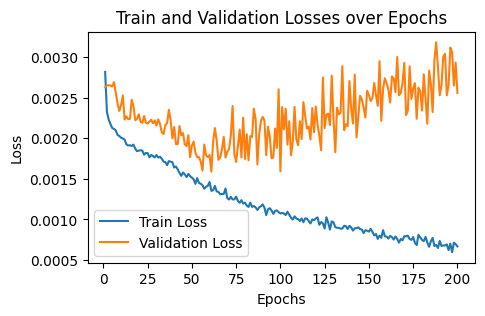

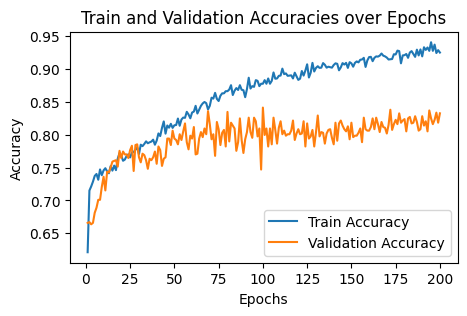

In [31]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [31]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/3000_Transformer_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 16.44it/s]

Best epoch: 100
macro F1 Score: 0.6688170001344947
AUROC: 0.8784293129016313
Accuracy: 0.74945295404814


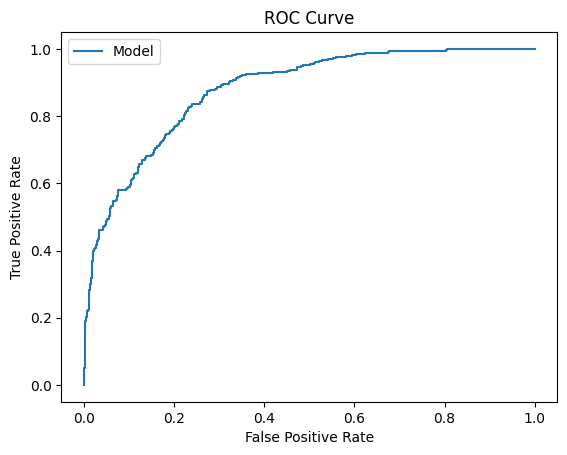

: 

In [33]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)